Workshop 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Understanding and Visualization

In [ ]:
import os

train_dir = "/content/drive/MyDrive/Deep_Learning /FruitinAmazon/train"
class_names = sorted(os.listdir(train_dir))
print(f"Found {len(class_names)} classes: {class_names}")


Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Check and remove corrupted images

In [ ]:
from PIL import Image, UnidentifiedImageError

corrupted_images = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()
        except (IOError, UnidentifiedImageError):
            corrupted_images.append(img_path)
            os.remove(img_path)

print("Corrupted images removed:", corrupted_images if corrupted_images else "None")


Corrupted images removed: None


Check class balance

In [ ]:
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    class_counts[class_name] = len(images)

print("\nClass Distribution:")
for k, v in class_counts.items():
    print(f"{k}: {v} images")



Class Distribution:
acai: 15 images
cupuacu: 15 images
graviola: 15 images
guarana: 15 images
pupunha: 15 images
tucuma: 15 images


Visualize one image per class

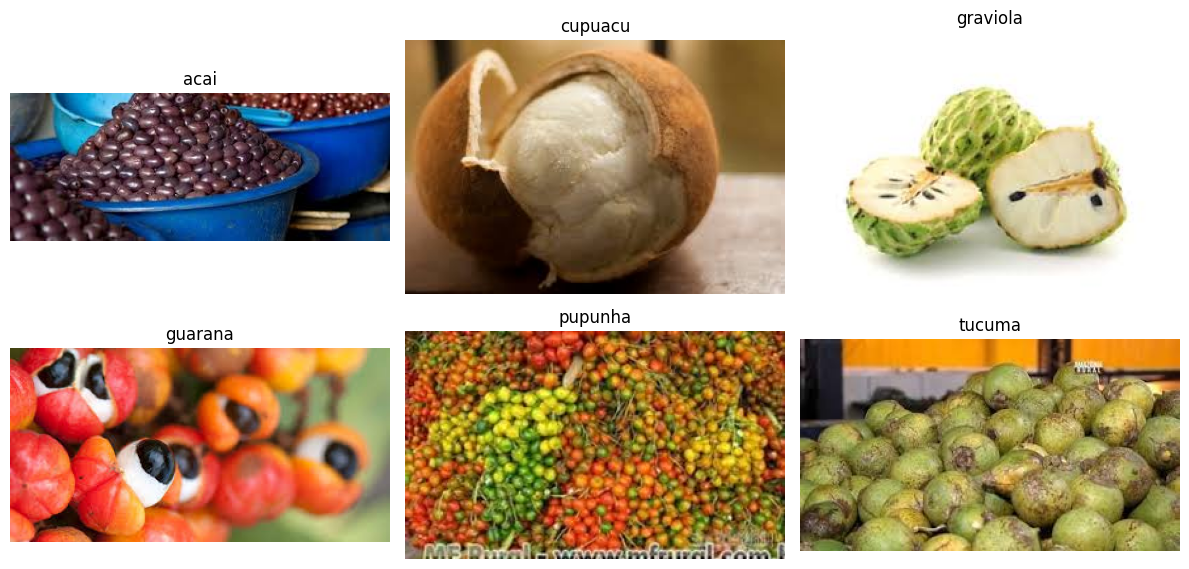

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    selected_images.append(os.path.join(class_path, img_name))
    selected_labels.append(class_name)

cols = (len(selected_images) + 1) // 2
fig, axes = plt.subplots(2, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis('off')
plt.tight_layout()
plt.show()


 Load & Preprocess Dataset (with Augmentation)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Define augmentation + rescaling
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.Rescaling(1./255)
])

# 2. Load raw datasets
image_size = (224, 224)
batch_size = 32

raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# 3. Get class names
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# 4. Apply augmentation to train set only
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 5. Apply rescaling only to val set
val_ds = val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

# ✅ 6. Add caching, shuffling, prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


 Build the Improved CNN Model with BN + Dropout

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

model = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Block 1
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(64), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,670 (100.17 MB)

 Trainable params: 26,254,790 (100.15 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [ ]:
# Load unmodified dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=8  # Small batch for easier visualization
)

# Get a batch (one batch = 8 images)
for images, labels in raw_train_ds.take(1):
    original_images = images
    augmented_images = data_augmentation(images)


Found 90 files belonging to 6 classes.
Using 72 files for training.


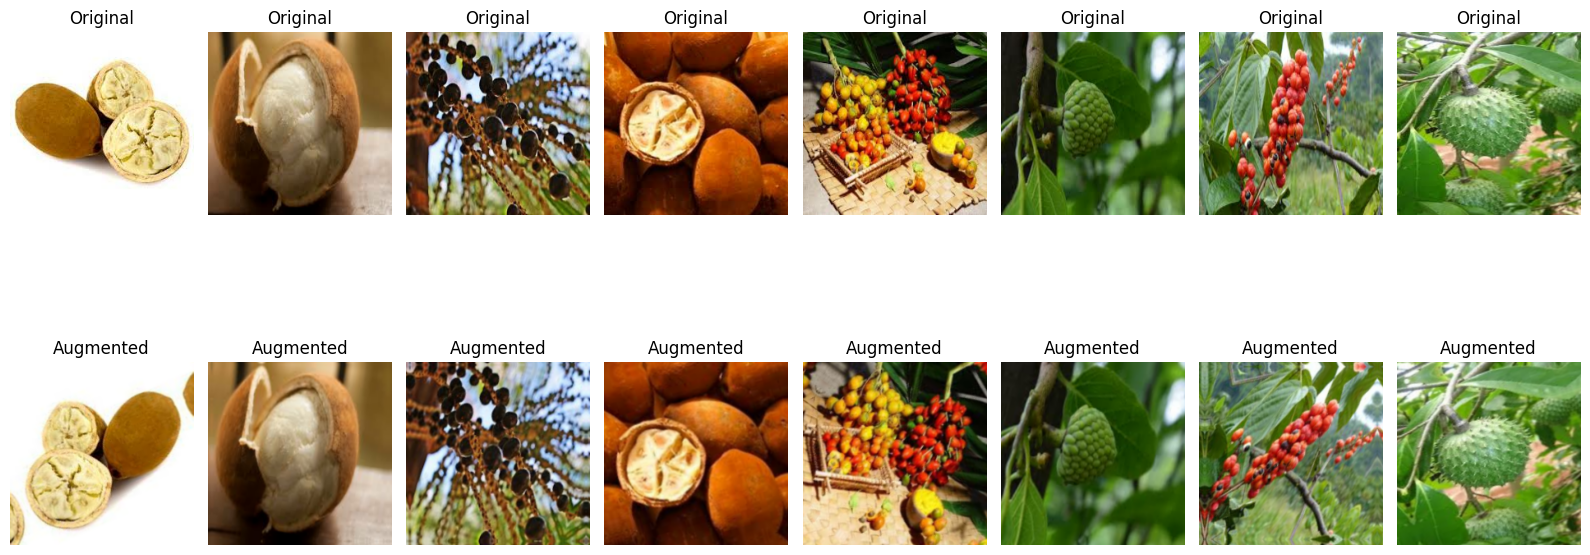

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

for i in range(8):
    # Original image
    plt.subplot(2, 8, i + 1)
    plt.imshow(original_images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis('off')

    # Augmented image
    plt.subplot(2, 8, i + 9)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()


 Train and Evaluate the Model

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.1819 - loss: 2.4922 - val_accuracy: 0.2222 - val_loss: 1.7949
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.2220 - loss: 2.3563 - val_accuracy: 0.1111 - val_loss: 1.7944
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.1654 - loss: 2.3909 - val_accuracy: 0.0556 - val_loss: 1.8120
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.1732 - loss: 2.4294 - val_accuracy: 0.1111 - val_loss: 1.8802
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.2151 - loss: 2.0815 - val_accuracy: 0.0556 - val_loss: 1.9497
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step - accuracy: 0.2618 - loss: 1.9991 - val_accuracy: 0.0556 - val_loss: 2.0126
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.2826 - loss: 1.8996 - val_accuracy: 0.0556 - val_loss: 2.0755
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step - accuracy: 0.2028 - loss: 2.1247 - val_accuracy: 0.1111 - val_loss: 2.1454
Epoch 9/

Use Transfer Learning with VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# STEP 1: Load base model with frozen layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze everything initially

# STEP 2: Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

# STEP 3: Compile and train (Phase 1)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_vgg.fit(train_ds, validation_data=val_ds, epochs=10)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 52s 17s/step - accuracy: 0.1668 - loss: 1.9701 - val_accuracy: 0.3333 - val_loss: 1.8165
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 16s/step - accuracy: 0.4375 - loss: 1.7029 - val_accuracy: 0.3333 - val_loss: 1.5992
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 15s/step - accuracy: 0.6085 - loss: 1.3809 - val_accuracy: 0.5000 - val_loss: 1.6062
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 17s/step - accuracy: 0.7344 - loss: 1.2514 - val_accuracy: 0.4444 - val_loss: 1.5203
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 22s/step - accuracy: 0.7861 - loss: 0.9294 - val_accuracy: 0.5556 - val_loss: 1.4364
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 21s/step - accuracy: 0.7609 - loss: 0.9799 - val_accuracy: 0.5556 - val_loss: 1.3796
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 26s/step - accuracy: 0.8854 - loss: 0.6965 - val_accuracy: 0.5556 - val_loss: 1.3833
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 16s/step - accuracy: 0.8494 - loss

Add Custom Layers

In [ ]:
# STEP 4: Unfreeze the last few layers
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Freeze all except last 4
    layer.trainable = False

# STEP 5: Recompile with lower learning rate
model_vgg.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# STEP 6: Continue training (fine-tuning)
history_fine = model_vgg.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 61s 19s/step - accuracy: 0.9861 - loss: 0.2238 - val_accuracy: 0.6667 - val_loss: 1.1379
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 20s/step - accuracy: 0.9861 - loss: 0.1752 - val_accuracy: 0.6111 - val_loss: 1.1424
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 18s/step - accuracy: 0.9580 - loss: 0.1888 - val_accuracy: 0.6667 - val_loss: 1.1109
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 58s 19s/step - accuracy: 0.9891 - loss: 0.1389 - val_accuracy: 0.7222 - val_loss: 1.0805
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 19s/step - accuracy: 1.0000 - loss: 0.1136 - val_accuracy: 0.7778 - val_loss: 1.0572


Train and Evaluate VGG Model

In [ ]:
model_vgg.fit(train_ds, validation_data=val_ds, epochs=10)

vgg_loss, vgg_acc = model_vgg.evaluate(val_ds)
print(f"VGG16 Transfer Learning Accuracy: {vgg_acc:.4f}")


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 23s/step - accuracy: 0.0994 - loss: 1.9455 - val_accuracy: 0.2778 - val_loss: 1.7766
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 20s/step - accuracy: 0.3602 - loss: 1.5982 - val_accuracy: 0.4444 - val_loss: 1.7117
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 18s/step - accuracy: 0.4970 - loss: 1.4103 - val_accuracy: 0.3333 - val_loss: 1.7041
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 22s/step - accuracy: 0.5326 - loss: 1.2789 - val_accuracy: 0.5000 - val_loss: 1.5117
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 23s/step - accuracy: 0.7409 - loss: 1.1057 - val_accuracy: 0.5556 - val_loss: 1.4883
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 18s/step - accuracy: 0.7556 - loss: 0.9964 - val_accuracy: 0.4444 - val_loss: 1.4975
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step - accuracy: 0.8012 - loss: 0.9307 - val_accuracy: 0.5556 - val_loss: 1.4389
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 18s/step - accuracy: 0.8316 - loss: 0.8207 - val_accuracy: 0.5556 - val_loss: 1.3969


Classification Report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
y_true = np.concatenate([y for x, y in val_ds])

# Get predictions
y_pred_probs = model_vgg.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
              precision    recall  f1-score   support

        acai       0.50      0.33      0.40         3
     cupuacu       0.29      0.50      0.36         4
    graviola       0.00      0.00      0.00         1
     guarana       0.25      0.33      0.29         3
     pupunha       0.00      0.00      0.00         4
      tucuma       0.00      0.00      0.00         3

    accuracy                           0.22        18
   macro avg       0.17      0.19      0.17        18
weighted avg       0.19      0.22      0.20        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
